# Regression Predict Student Solution

© Explore Data Science Academy

---
### Honour Code

I {**SIFISO, SHABANGU**}, confirm - by submitting this document - that the solutions in this notebook are a result of my own work and that I abide by the [EDSA honour code](https://drive.google.com/file/d/1QDCjGZJ8-FmJE3bZdIQNwnJyQKPhHZBn/view?usp=sharing).

Non-compliance with the honour code constitutes a material breach of contract.

### Predict Overview: EDSA - Twitter Sentiment Classification

Many companies are built around lessening one’s environmental impact or carbon footprint. They offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. They would like to determine how people perceive climate change and whether or not they believe it is a real threat. This would add to their market research efforts in gauging how their product/service may be received.[Kaggle](https://www.kaggle.com/competitions/edsa-sentiment-classification/overview/description)


Problem statement :

> With this context, EDSA is challenging you during the Classification Sprint with the task of creating a Machine Learning model that is able to classify whether or not a person believes in climate change, based on their novel tweet data..
 

<a id="cont"></a>

## Table of Contents

<a href=#one>1. Importing Packages</a>

<a href=#two>2. Loading Data</a>

<a href=#three>3. Exploratory Data Analysis (EDA)</a>

<a href=#four>4. Data Engineering</a>

<a href=#five>5. Modeling</a>

<a href=#six>6. Model Performance</a>

<a href=#seven>7. Model Explanations</a>

 <a id="one"></a>
## 1. Importing Packages
<a href=#cont>Back to Table of Contents</a>

Packages below will be used in sub-sequent sections

In [1]:
from comet_ml import Experiment
experiment = Experiment(
  api_key = "",
  project_name = "predict2",
  workspace="sfisoc"
)

In [2]:
# Libraries for data loading, data manipulation and data visulisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Libraries for data preparation and model building
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error # for checking performance
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import string
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from nltk.tokenize import word_tokenize, TreebankWordTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDClassifier

# Setting global constants to ensure notebook results are reproducible
# PARAMETER_CONSTANT = ###

[nltk_data] Downloading package stopwords to C:\Users\House of
[nltk_data]     Mind\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<a id="two"></a>
## 2. Loading the Data
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

The [data](https://www.kaggle.com/competitions/edsa-sentiment-classification/data) is downaloded from Kaggle and consists of csv file of tweets.

Below describe the data columns:
##### Class Description
- 2 News: the tweet links to factual news about climate change

- 1 Pro: the tweet supports the belief of man-made climate change

- 0 Neutral: the tweet neither supports nor refutes the belief of man-made climate change

- -1 Anti: the tweet does not believe in man-made climate change Variable definitions

##### Features


- **sentiment** : Which class a tweet belongs in (refer to Class Description above)

- **message** : Tweet body

- **tweetid** : Twitter unique id



In [3]:
# df = # load the data
df_train = pd.read_csv("train.csv")
df_train.head(3)

sentiment                                            message  tweetid
0          1  PolySciMajor EPA chief doesn't think carbon di...   625221
1          1  It's not like we lack evidence of anthropogeni...   126103
2          2  RT @RawStory: Researchers say we have three ye...   698562

In [4]:
df_test = pd.read_csv("test_with_no_labels.csv")
df_test.head(3)

message  tweetid
0  Europe will now be looking to China to make su...   169760
1  Combine this with the polling of staffers re c...    35326
2  The scary, unimpeachable evidence that climate...   224985

<a id="three"></a>
## 3. Exploratory Data Analysis (EDA)
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

This section will look explora the data


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


In [6]:
df_train.isnull().sum()

sentiment    0
message      0
tweetid      0
dtype: int64

In [7]:
df_train.shape

(15819, 3)

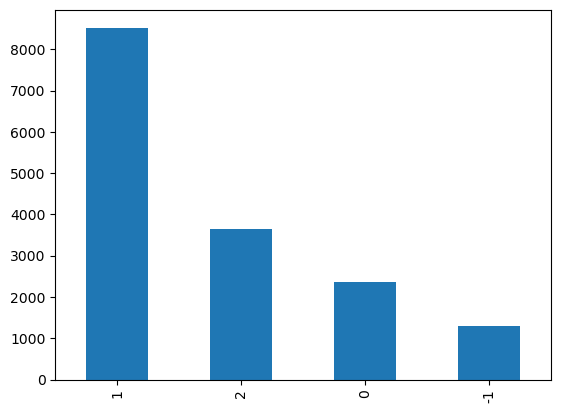

In [8]:
df_train['sentiment'].value_counts().plot(kind = 'bar')
plt.show()

<a id="four"></a>
## 4. Data Engineering
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

In this section will clean the data

In [9]:
## Remove urls
print ('Removing URLs...')

def removeURLS(df,col):
    df_copy = df.copy()
    pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
    subs_url = r'urlweb'
    df_copy[col] = df_copy[col].replace(to_replace = pattern_url, value = subs_url, regex = True)
    
    return df_copy

df_train = removeURLS(df_train,'message')    


Removing URLs...


In [10]:
# Make lower case
print ('Lowering case...')

def toLower(df,col):
    df_copy = df.copy()
    df_copy[col] = df_copy[col].str.lower()
    
    return df_copy

df_train = toLower(df_train,'message')    


Lowering case...


In [11]:
print ('Cleaning punctuation...')

def remove_punctuation_numbers(message):
    punc_numbers = string.punctuation + '0123456789'
    return ''.join([l for l in message if l not in punc_numbers])

df_train['message'] = df_train['message'].apply(remove_punctuation_numbers)



Cleaning punctuation...


In [12]:
def remove_stop_words(message):
    print(message)
    return ''.join([t for t in message if t not in stopwords.words('english')])

df_train['message'] = df_train['message'].apply(remove_stop_words)


In [14]:
print("Save clean data")
df_train.to_csv('clean_df.csv',index=False)


Save clean data


In [35]:
df_train  = pd.read_csv("clean_df.csv")

In [15]:
# engineer existing features
vect = CountVectorizer(stop_words=stopwords.words('english'))
X = vect.fit_transform(df_train['message'])

<a id="five"></a>
## 5. Modelling
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

In this secction will build models for the data

In [16]:
# split data
y = df_train['sentiment']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=36)

In [18]:
# create one or more ML models
names = ['Logistic Regression', 
         'Linear SVM',          
         'SGDClassifier']

In [19]:
# Models instances
classifiers = [
    LogisticRegression(max_iter=3000), 
    SVC(C=0.025),
    SGDClassifier(loss="hinge", penalty="l2")
]

In [20]:
results = []

models = {}
confusion = {}
class_report = {}


for name, clf in zip(names, classifiers):    
    print ('Fitting {:s} model...'.format(name))
    run_time = %timeit -q -o clf.fit(X_train, y_train)
    
    print ('... predicting')
    y_pred = clf.predict(X_train)   
    y_pred_test = clf.predict(X_test)
    
    print ('... scoring')
    accuracy  = metrics.accuracy_score(y_train, y_pred)
    precision = metrics.precision_score(y_train, y_pred,average='weighted')
    recall    = metrics.recall_score(y_train, y_pred,average='weighted')
    
    f1        = metrics.f1_score(y_train, y_pred,average='weighted')    
    f1_test   = metrics.f1_score(y_test, y_pred_test,average='weighted')    
    
    # Save the results to dictionaries
    models[name] = clf    
    confusion[name] = metrics.confusion_matrix(y_train, y_pred)
    class_report[name] = metrics.classification_report(y_train, y_pred)
    
    results.append([name, accuracy, precision, recall, f1, f1_test, run_time.best])
    
results = pd.DataFrame(results, columns=['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1 Train', 'F1 Test', 'Train Time'])
results.set_index('Classifier', inplace= True)

print ('... All done!')

Fitting Logistic Regression model...
... predicting
... scoring
Fitting Linear SVM model...
... predicting
... scoring
Fitting SGDClassifier model...


C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classifi

... predicting
... scoring
... All done!


<a id="six"></a>
## 6. Model Performance
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

In this section we look at the model performance and predict the test data

---

In [21]:
# Compare model performance
results.sort_values('F1 Test', ascending=False)

Accuracy  Precision    Recall  F1 Train   F1 Test  \
Classifier                                                               
Logistic Regression  0.975346   0.975508  0.975346  0.975266  0.747052   
SGDClassifier        0.983722   0.983788  0.983722  0.983705  0.743030   
Linear SVM           0.549348   0.494131  0.549348  0.402279  0.400005   

                     Train Time  
Classifier                       
Logistic Regression    3.232953  
SGDClassifier          0.147264  
Linear SVM            24.839706

In [22]:
# Clean up test data 

df_test = removeURLS(df_test,'message')    

df_test = toLower(df_test,'message')    

df_test['message'] = df_test['message'].apply(remove_punctuation_numbers)

X_test_sub = vect.transform(df_test['message'])



In [23]:
# predict using test data and the most perfomring model
y_predict =  models['Logistic Regression'].predict(X_test_sub)

tweetsids = df_test.iloc[:,1].values

output = pd.DataFrame({'tweetid': tweetsids, 'sentiment': y_predict})
output.to_csv('submission_p2.csv', index=False)

In [24]:
# Save model
import pickle

model_save_path = "modelp2.pkl"
with open(model_save_path,'wb') as file:
    pickle.dump(models['Logistic Regression'],file)

<a id="seven"></a>
## 7. Model Explanations
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

The most perfoment model is the Logistic Regression, others struggle due to imbalance in data

In [25]:
results.sort_values('F1 Test', ascending=False)

Accuracy  Precision    Recall  F1 Train   F1 Test  \
Classifier                                                               
Logistic Regression  0.975346   0.975508  0.975346  0.975266  0.747052   
SGDClassifier        0.983722   0.983788  0.983722  0.983705  0.743030   
Linear SVM           0.549348   0.494131  0.549348  0.402279  0.400005   

                     Train Time  
Classifier                       
Logistic Regression    3.232953  
SGDClassifier          0.147264  
Linear SVM            24.839706